# TRGAN
### Kirill Zakharov
### Supervisors: Elizaveta Stavinova, Anton Lysenko

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm
from TRGAN.comparison import compare_amount, compare_categorical
from TRGAN.time_generation import synthetic_deltas

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

### Import data

In [9]:
from TRGAN.dataset.catalog import czech_bank


data, metadata = czech_bank()

In [10]:
data.head()

,customer,amount,mcc,transaction_date
0,576,900.0,cash_cr,1993-01-01
1,704,1000.0,cash_cr,1993-01-01
2,2378,700.0,cash_cr,1993-01-01
3,3818,600.0,cash_cr,1993-01-01
4,1972,400.0,cash_cr,1993-01-02


In [11]:
data.shape

(1056018, 4)

### Initialize all constants

In [12]:
from TRGAN.TRGAN import TRGANDataset


data_wrapped = TRGANDataset(
    data, 
    metadata,
    n_splits=4
)


100%|██████████| 4480/4480 [08:04<00:00,  9.24it/s]


Text(0.5, 1.0, 'Distribution of time between two transactions')

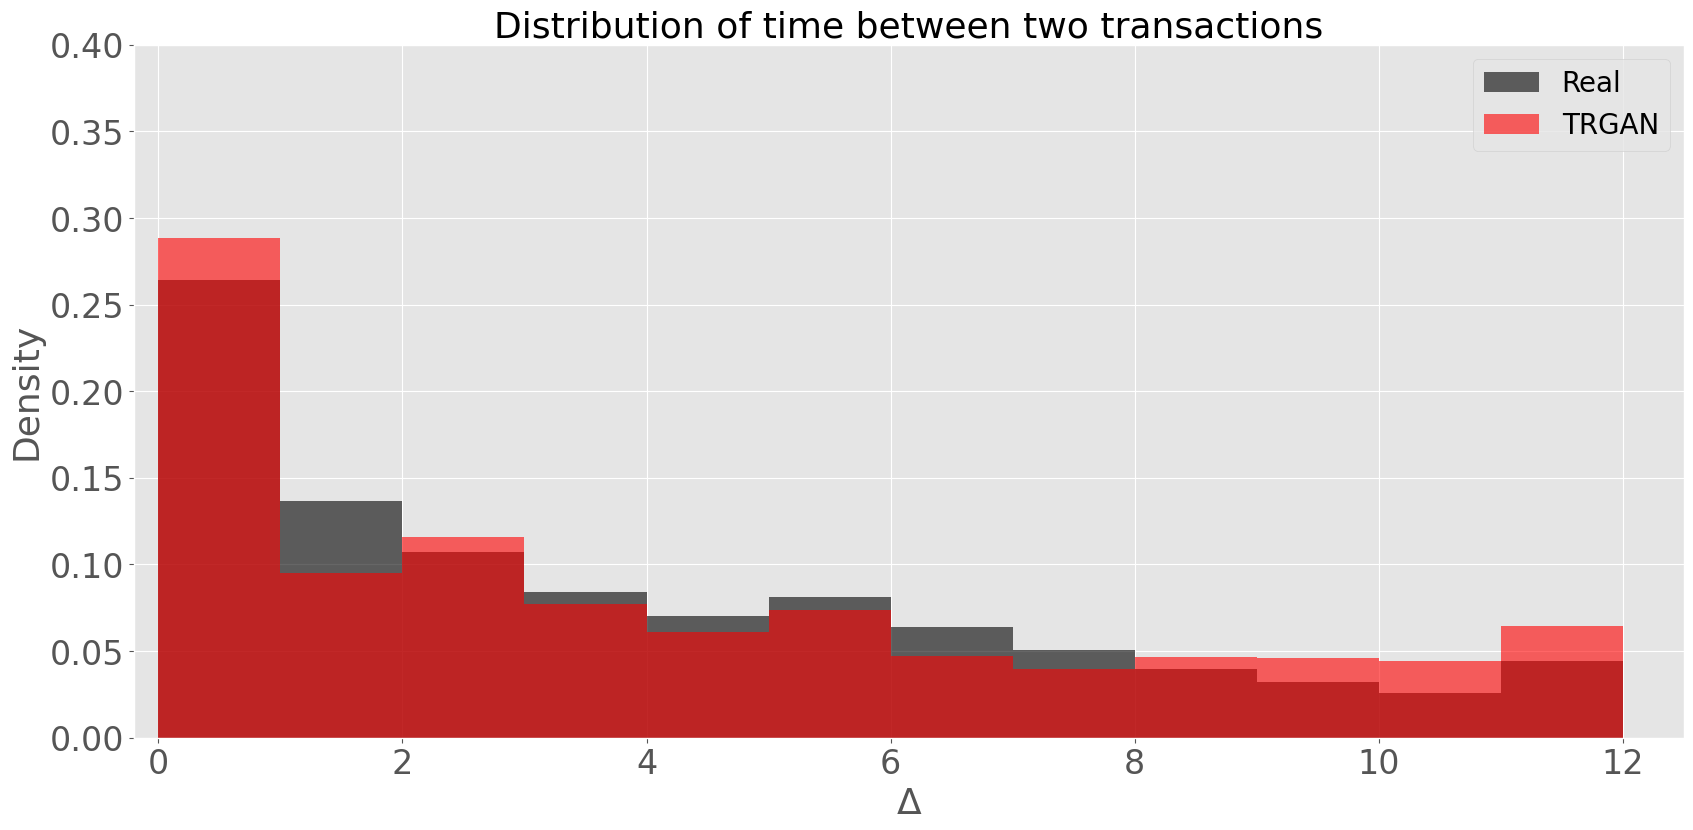

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(20, 9), dpi=100)
axs.hist(
    np.concatenate(data_wrapped.deltas.values),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="Real",
    density=True,
    color="black",
)
axs.hist(
    synthetic_deltas(data_wrapped),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="TRGAN",
    density=True,
    color="red",
)

axs.legend(fontsize=20)
axs.set_xlabel("$\Delta$", fontsize=26)
axs.set_ylabel("Density", fontsize=26)
axs.tick_params(labelsize=24)
axs.locator_params(axis="x", integer=True)
axs.set_ylim((0, 0.4))
axs.set_xlim((-0.2, 12.5))
axs.set_title("Distribution of time between two transactions", fontsize=26)


In [13]:

from TRGAN.TRGAN import TRGAN, TRGANConfig
from TRGAN.feature_extractor import default_feature_extractor_config


model = TRGAN(
    metadata=metadata,
    config= TRGANConfig(
        num_epochs=30,
        clip_gradient_d1=0.0001,
        clip_gradient_d2=0.0001,
        feature_extraction =  default_feature_extractor_config(20)
    ),
    device="cpu"
)
model.train_extractor(data_wrapped)

E_oh with (AutoEncoderConfig(dimension=30, learning_rate=5e-05, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=300.0, differential_privacy=True), 0.1)-Differential Privacy


Loss Categorical features embedder: 0.000000000 : 100%|██████████| 20/20 [06:06<00:00, 18.30s/it]


E_oh with (AutoEncoderConfig(dimension=12, learning_rate=0.0008, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


Loss Continuous features embedder: 0.000000001 : 100%|██████████| 20/20 [07:27<00:00, 22.37s/it]


E_oh with (AutoEncoderConfig(dimension=4, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


Loss Client features embedder: 0.000000179 : 100%|██████████| 20/20 [06:42<00:00, 20.14s/it]


E_oh with (AutoEncoderConfig(dimension=10, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


Loss Condition vector embedder: 0.000008875 : 100%|██████████| 20/20 [10:02<00:00, 30.12s/it]


# validating autoencoders

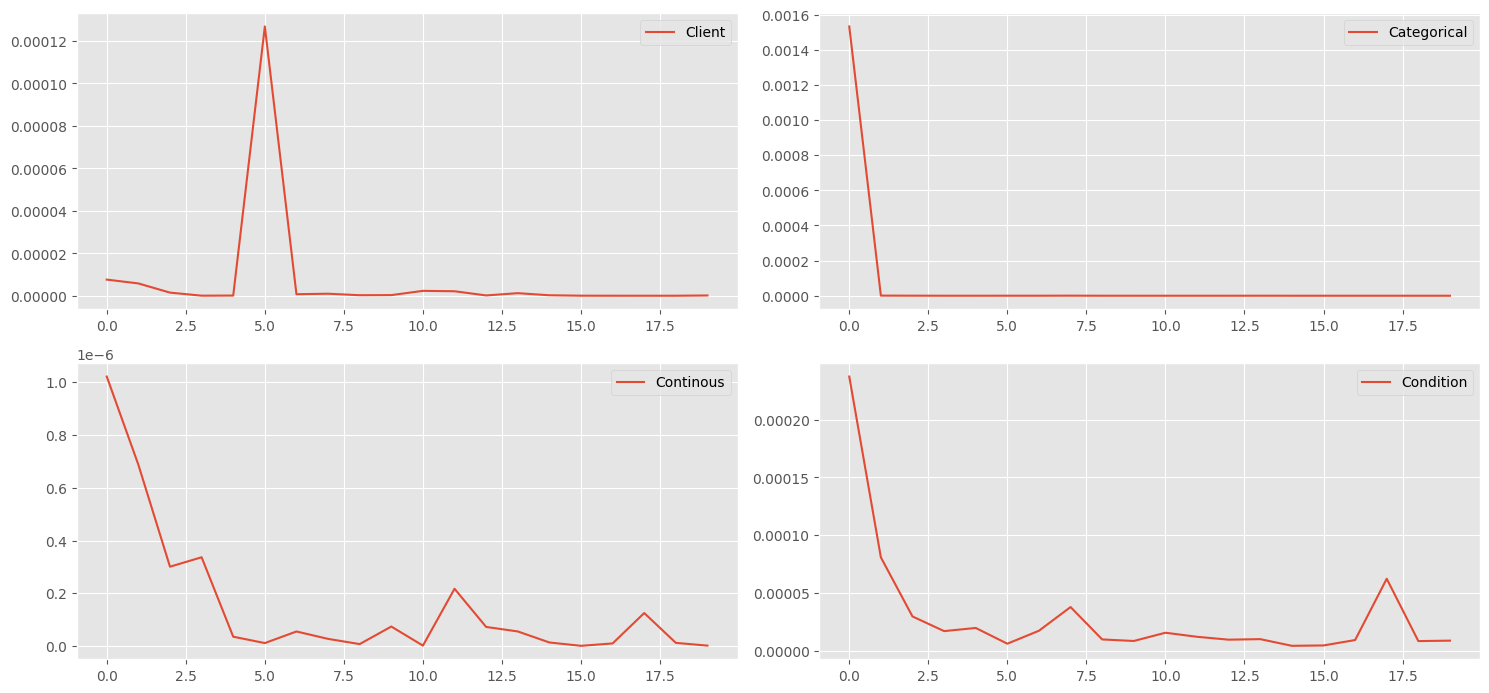

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15, 7))
ax[0,0].plot(model.feature_extractor.client_embedder.history, label="Client")
ax[0,1].plot(model.feature_extractor.categorical_embedder.history,label="Categorical")
ax[1,0].plot(model.feature_extractor.continous_embedder.history, label="Continous")
ax[1,1].plot(model.feature_extractor.condition_vector_embedded.history, label="Condition")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
fig.tight_layout()

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

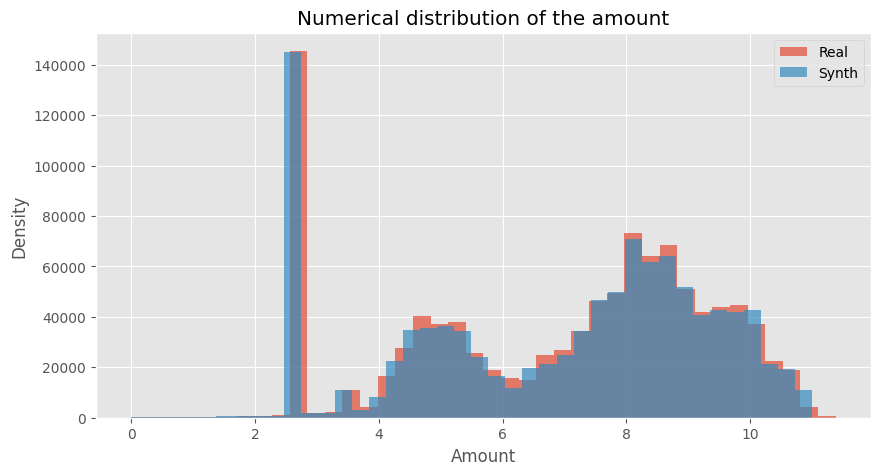

In [18]:
continous_embedder = model.feature_extractor.continous_embedder
rr = continous_embedder.inverse_transform(
    continous_embedder.encode(
        data[["amount"]]
    )
)

compare_amount(data.amount, rr.amount)


0.9999782200682186

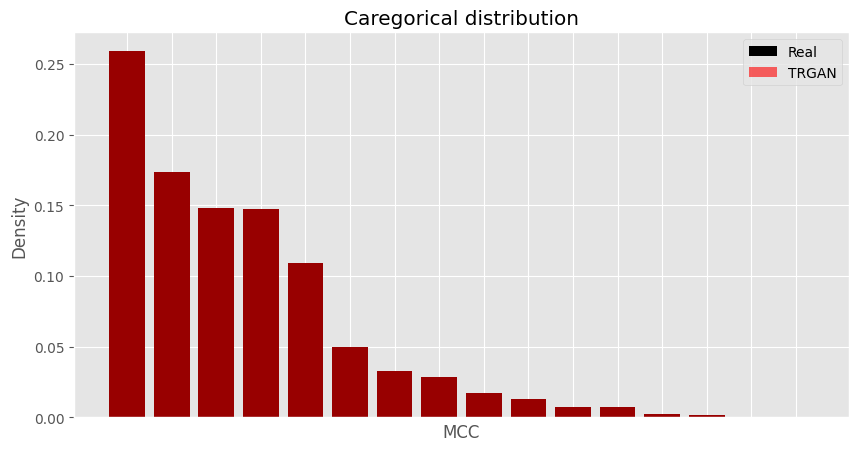

In [21]:
categorical_embedder = model.feature_extractor.categorical_embedder
qq = categorical_embedder.inverse_transform(
    categorical_embedder.encode(
        data[["mcc"]]
    )
)

compare_categorical(data.mcc, qq.mcc)
df_cat = pd.concat([data.mcc, qq.mcc], axis=1)
df_cat.columns = ["real", "synthetic"]
(df_cat["real"].astype("str") == df_cat["synthetic"].astype("str")).mean()

In [60]:
model.config= TRGANConfig(
        num_epochs=30,
        clip_gradient_d1=0.0005,
        clip_gradient_d2=0.0005,
        batch_size=2**9,
        lr_discriminator=5e-4,
        feature_extraction =  default_feature_extractor_config(20)
)
model.build_GAN()
model.train_GAN(data_wrapped)

Discriminator Loss: -0.00000 || Discriminator 2 Loss: -0.00000 || Generator Loss: 0.00098 || Supervisor Loss: 0.00241:  43%|████▎     | 13/30 [24:39<32:14, 113.81s/it]

nan
nan
nan
nan


model.train_GAN(data_wrapped)

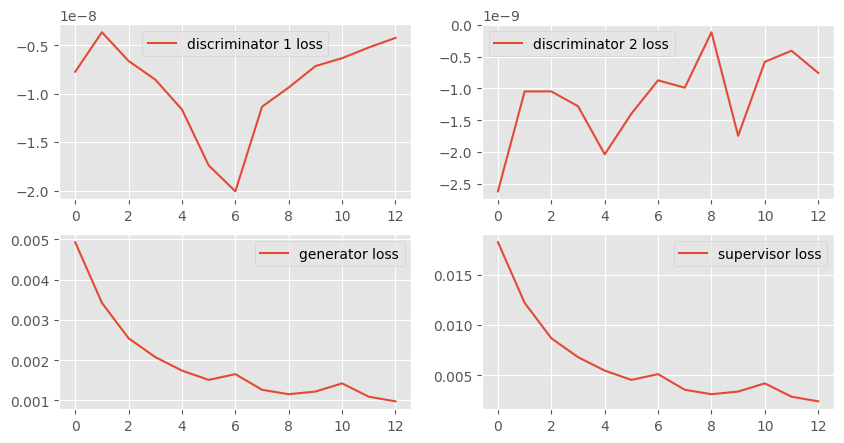

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(model.loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(model.loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(model.loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(model.loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

### Synth time comparison 

In [52]:
rr = model.sample(data_wrapped, 1056018).rename(columns={'date': 'transaction_date'})

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

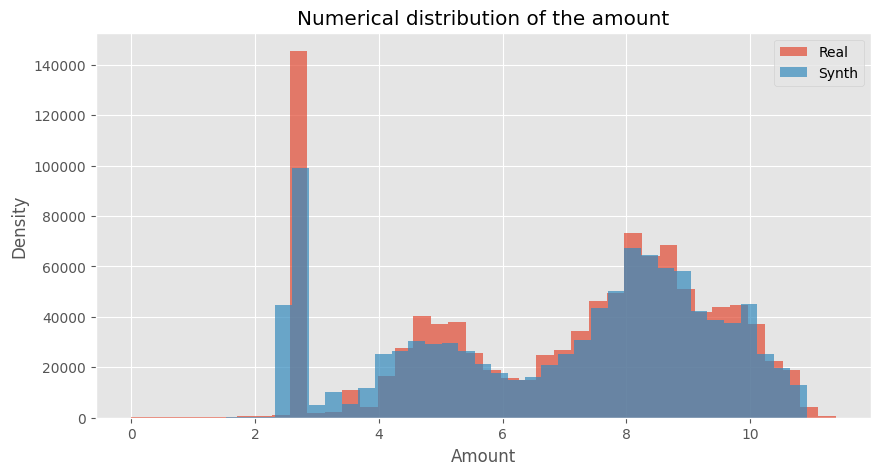

In [53]:
compare_amount(data.amount, rr.amount, ax=None, label="Synth")


<Axes: title={'center': 'Caregorical distribution'}, xlabel='MCC', ylabel='Density'>

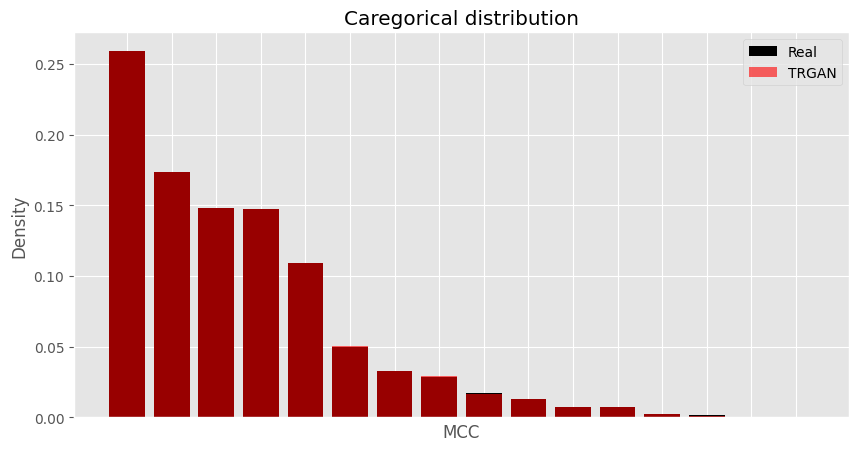

In [54]:

compare_categorical(
    data.mcc,
    rr.mcc
)

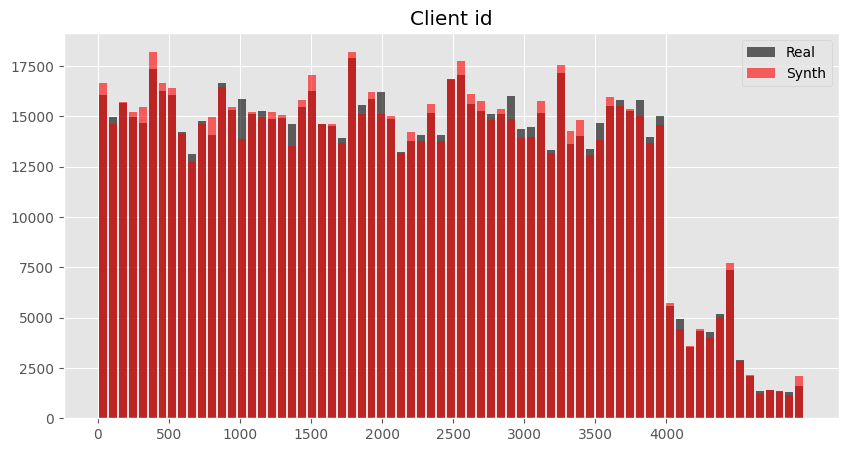

In [55]:
fig, axs = plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(
    data["customer"],
    alpha=0.6,
    label="Real",
    bins=np.arange(0, 5000, 70),
    color="black",
    rwidth=0.8,
)
plt.hist(
    rr["customer"],
    alpha=0.6,
    label="Synth",
    bins=np.arange(0, 5000, 70),
    color="red",
    rwidth=0.8,
)

plt.legend()
plt.xticks(
    np.arange(0, len(data["customer"].value_counts()), 500),
    np.arange(0, len(data["customer"].value_counts()), 500),
)
plt.title("Client id")

plt.show()

Text(0.5, 1.0, 'log(1 + Monthly Cash flow)')

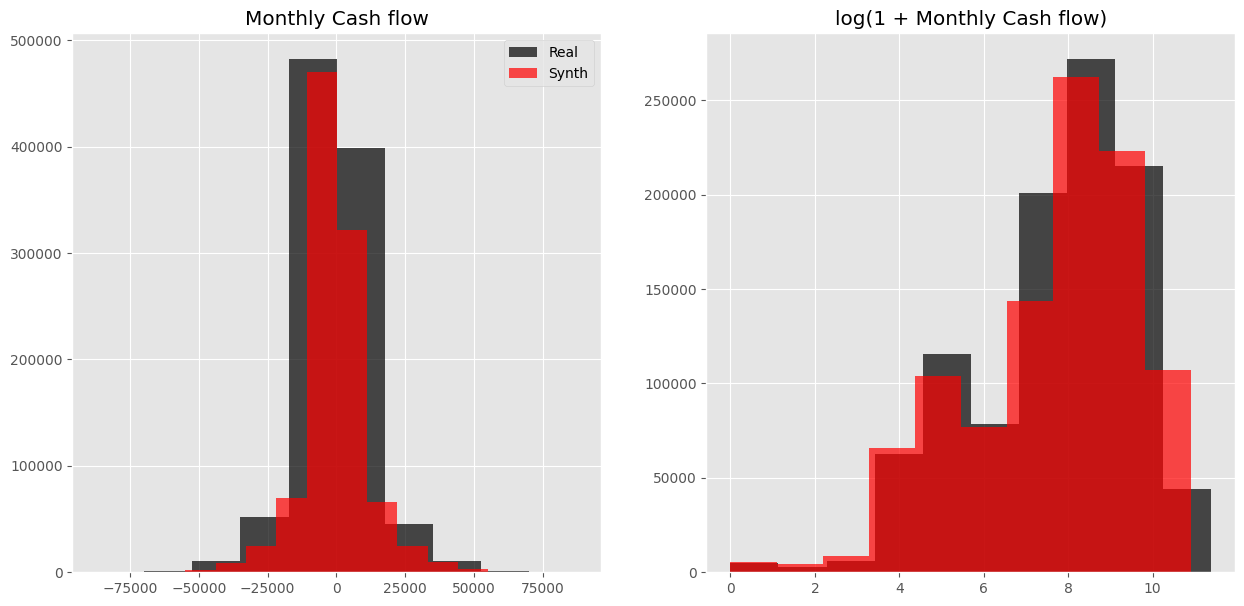

In [57]:
from TRGAN.comparison import get_cashflow


fig,ax = plt.subplots(1, 2, figsize=(15, 7), dpi=100)
cash_flow_real = get_cashflow(data)
cash_flow_synth = get_cashflow(rr, data.customer)

ax[0].hist(cash_flow_real, alpha=0.7, color="black", label="Real")
ax[0].hist(cash_flow_synth,  alpha=0.7, color="red", label="Synth")
ax[0].set_title("Monthly Cash flow")
ax[0].legend()

ax[1].hist(np.log1p(np.abs(cash_flow_real)),  color="black", alpha=0.7,label="Real")
ax[1].hist(np.log1p(np.abs(cash_flow_synth)), color="red", alpha=0.7,label="Synth")
ax[1].set_title("log(1 + Monthly Cash flow)")